In [57]:
import utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

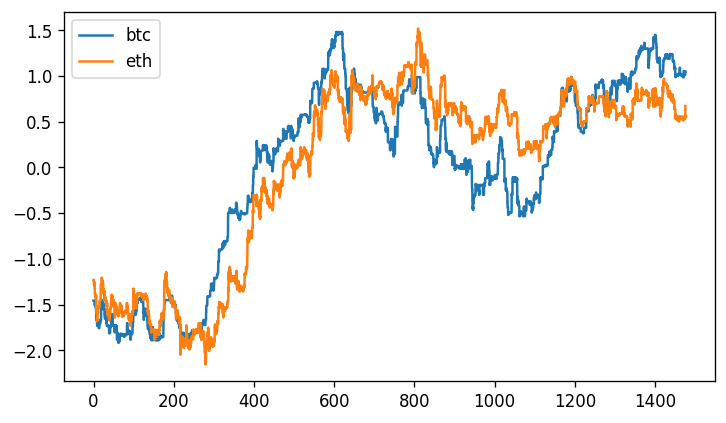

In [58]:
### PARAMETERS
products = ["btc", "eth"]
col_to_plot = "ask_price_min"
###

data_path = utilities.get_data_path(tree_level=2)
filenames = {}
dataframes = {}
scalers = {}

fig, ax = plt.subplots()

for product in products:
    filenames[product] = os.path.join(data_path, "datasets", f"{product}_stats_aligned.csv")
    dataframes[product] = pd.read_csv(filenames[product], index_col=0)

    # Normalize
    # scalers[product] = MinMaxScaler()
    scalers[product] = StandardScaler()

    dataframes[product] = pd.DataFrame(scalers[product].fit_transform(dataframes[product]),
                                       columns=dataframes[product].columns,
                                       index=dataframes[product].index)
    
    time = dataframes[product].index
    ax.plot(time, dataframes[product][col_to_plot], label=product)

x1 = dataframes[products[0]]
x2 = dataframes[products[1]]

plt.legend()
plt.show()

In [59]:
print("Średnia wartosc miedzy indeksami:", 5 * np.mean(x1.index.diff().dropna()))

Średnia wartosc miedzy indeksami: 0.2952740333360013


In [69]:
values = pd.Series(dataframes["btc"][col_to_plot].values)
values

0       -1.456733
1       -1.456733
2       -1.456733
3       -1.456733
4       -1.456733
           ...   
24984    1.049646
24985    1.049646
24986    1.049646
24987    1.049646
24988    1.049646
Length: 24989, dtype: float64

In [70]:
# See that that data is not stationary
result = adfuller(values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.242510
p-value: 0.655047


The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. For our example, we fail to reject the null hypothesis.

Next we difference our time series and check the results of the ADF test. We will also look at the ACF.


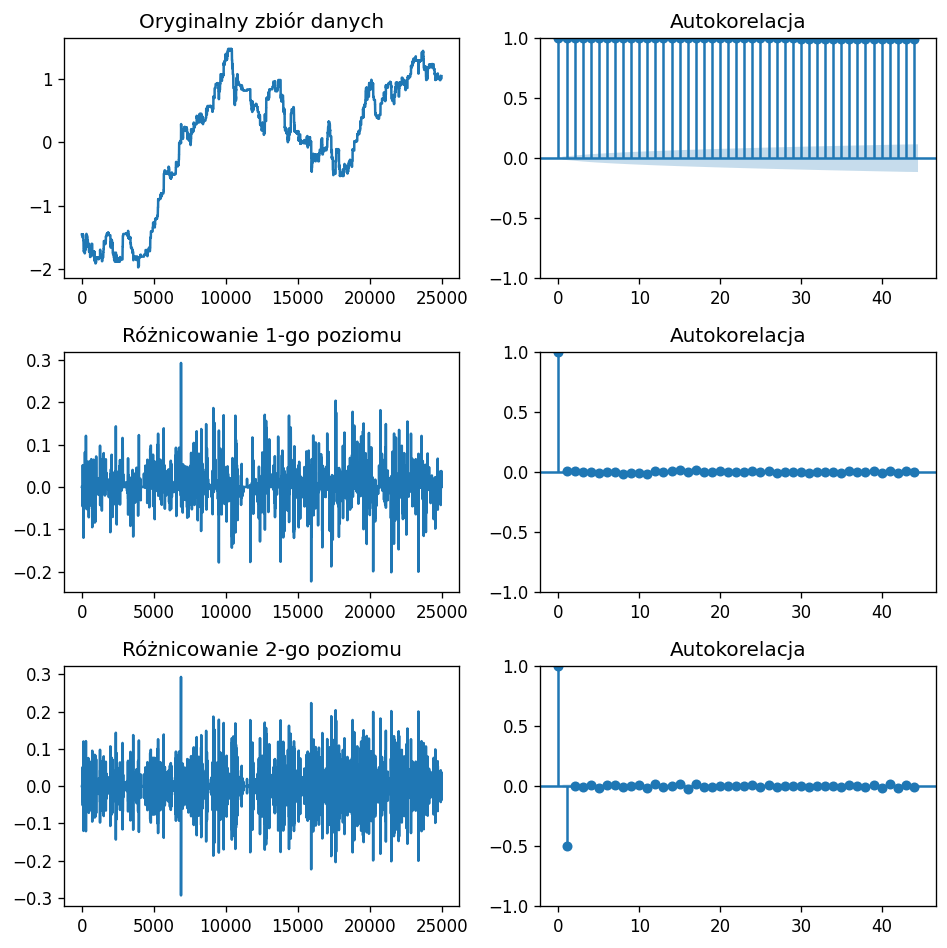

Statystyka ADF dla różnicowania 1-go poziomu
ADF Statistic: -36.829534
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -38.455912
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [71]:
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(values); axes[0, 0].set_title('Oryginalny zbiór danych')
plot_acf(values, ax=axes[0, 1], title="Autokorelacja")

# 1st Differencing
axes[1, 0].plot(values.diff()); axes[1, 0].set_title('Różnicowanie 1-go poziomu')
plot_acf(values.diff().dropna(), ax=axes[1, 1], title="Autokorelacja")

# 2nd Differencing
axes[2, 0].plot(values.diff().diff()); axes[2, 0].set_title('Różnicowanie 2-go poziomu')
plot_acf(values.diff().diff().dropna(), ax=axes[2, 1], title="Autokorelacja")

fig.tight_layout()
plt.savefig(os.path.join(data_path, "..", "graphics", f"arima_differencing.pdf"))
plt.show()

print('Statystyka ADF dla różnicowania 1-go poziomu')
result = adfuller(values.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(values.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

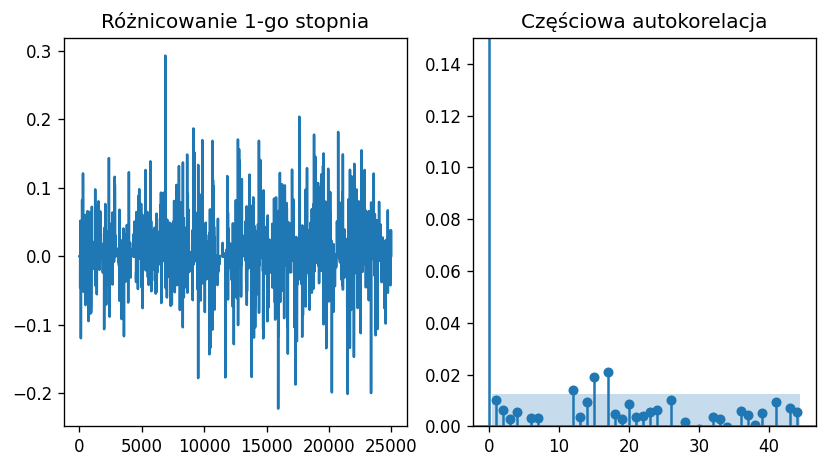

In [72]:
# AutoRegressive term p
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, figsize=(7,4))
axes[0].plot(values.diff())
axes[0].set_title('Różnicowanie 1-go stopnia')

plot_pacf(values.diff().dropna(), ax=axes[1], title="Częściowa autokorelacja")
axes[1].set(ylim=(0,0.15))
fig.tight_layout()
plt.savefig(os.path.join(data_path, "..", "graphics", f"arima_pacf.pdf"))
plt.show()

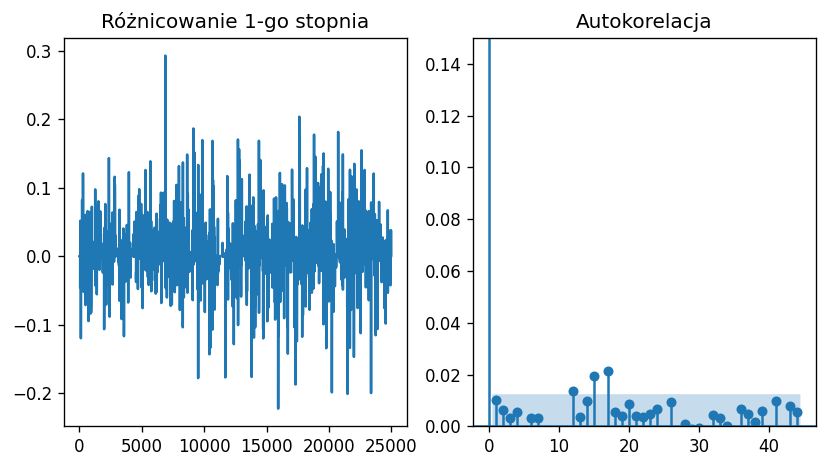

In [73]:
# Moving average term q
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(values.diff()); axes[0].set_title('Różnicowanie 1-go stopnia')

plot_acf(values.diff().dropna(), ax=axes[1], title="Autokorelacja")
axes[1].set(ylim=(0,0.15))

fig.tight_layout()
plt.savefig(os.path.join(data_path, "..", "graphics", f"arima_acf.pdf"))
plt.show()

In [74]:
# order=(p,d,q)
# p: The number of lag observations (lag order) in the model (AR component).
# d: The number of times raw observations are differenced (degree of differencing).
# q: The size of the moving average window (order of the moving average).
model = ARIMA(values, order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                24989
Model:                 ARIMA(1, 2, 0)   Log Likelihood               70518.311
Date:                Mon, 20 May 2024   AIC                        -141032.621
Time:                        22:48:42   BIC                        -141016.369
Sample:                             0   HQIC                       -141027.361
                              - 24989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4982      0.001   -395.397      0.000      -0.501      -0.496
sigma2         0.0002   3.53e-07    587.042      0.000       0.000       0.000
Ljung-Box (L1) (Q):                 676.47   Jarque-

W obrębie dyscypliny ekonometrii, fenomen heteroskedastyczności ujawnia się jako paradoks charakteryzujący się nieuniformną dyspersją residuów, co implikuje, że tradycyjne procedury estymacyjne, zakorzenione w założeniu homoskedastyczności, takie jak ortodoksyjna metoda najmniejszych kwadratów, mogą okazać się deficytarne. Nie inkorporują one bowiem potencjalnej heterogeniczności w zakresie dyspersji błędów losowych, co skutkuje imperatywem implementacji bardziej abstruzyjnych metod estymacyjnych. Przykładem są heteroskedastycznie konsystentne estymatory wariancji o charakterze uniwersalnym, które pozwalają na adekwatną korektę standardowych błędów, zapewniając tym samym bardziej wiarygodne wnioskowanie statystyczne.

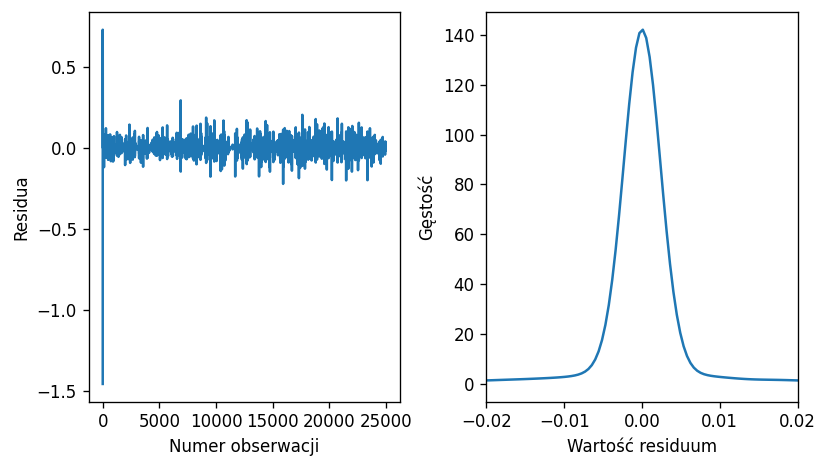

In [89]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(7,4))
residuals.plot(title=None, ax=ax[0], legend=False)
residuals.plot(kind='kde', ind=10000, title=None, ax=ax[1], legend=False)

ax[0].set_xlabel("Numer obserwacji")
ax[0].set_ylabel("Residua")
ax[1].set_xlim([-.02, .02])
ax[1].set_xlabel("Wartość residuum")
ax[1].set_ylabel("Gęstość")
fig.tight_layout()

plt.savefig(os.path.join(data_path, "..", "graphics", f"arima_residuals.pdf"))
plt.show()

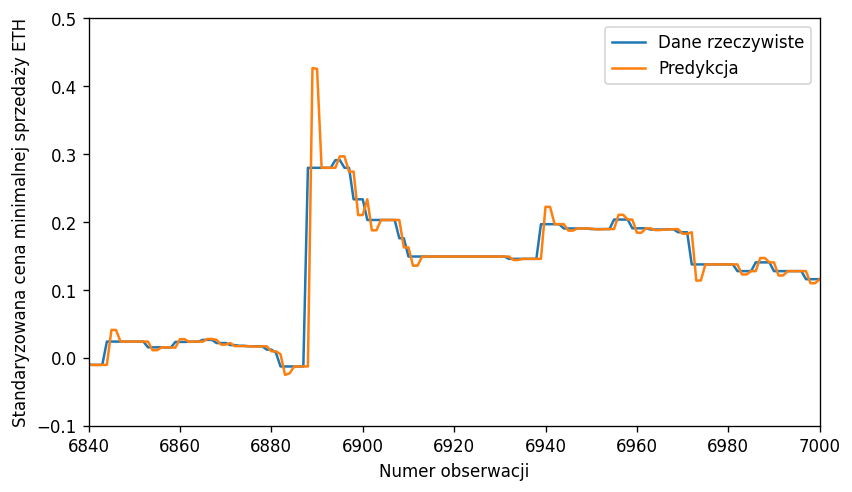

In [84]:
start = 6840
stop = 7000
fig, ax = plt.subplots(figsize=(7,4))
ax = values[start:].plot(ax=ax, label="Dane rzeczywiste")
# fig = plot_predict(model_fit, 85, 100, dynamic=False, ax=ax, plot_insample=False)
# fig = plot_predict(model_fit, start+50, stop, dynamic=False, ax=ax)
pred = model_fit.get_prediction(start=start, end=stop)
ax.plot(pred.predicted_mean, label="Predykcja")
plt.xlim([start, stop])
plt.ylim([-0.1, 0.5])
fig.tight_layout()
plt.legend()
plt.xlabel("Numer obserwacji")
plt.ylabel("Standaryzowana cena minimalnej sprzedaży ETH")
plt.savefig(os.path.join(data_path, "..", "graphics", f"arima_predicitions.pdf"))
plt.show()

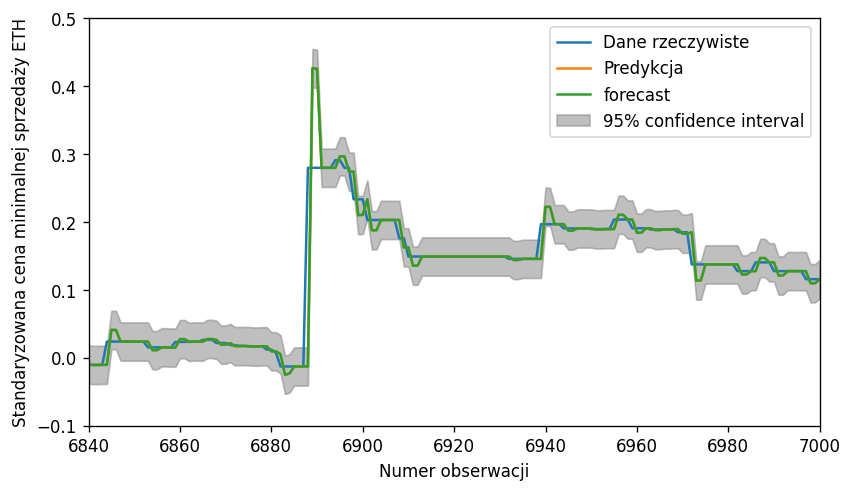

In [85]:
plot_predict(model_fit, start, stop, ax=ax)

# BELOW EXAMPLE

In [90]:
# EXAMPLE  !

# import matplotlib.pyplot as plt
# import pandas as pd
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_predict
# from statsmodels.tsa.arima.model import ARIMA

# dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
# dta.index = pd.date_range(start='1700', end='2009', freq='YE')
# res = ARIMA(dta, order=(0,2,0)).fit()
# fig, ax = plt.subplots()
# ax = dta.loc['1950':].plot(ax=ax)
# plot_predict(res, '1990', '2012', ax=ax)
# plt.show()

# GRANGER CASUALITY TESTS

In [119]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

data_btc = pd.Series(dataframes["btc"][col_to_plot]).rename("ask_price_min_btc")
data_eth = pd.Series(dataframes["eth"][col_to_plot]).rename("ask_price_min_eth")
data = pd.concat([data_btc, data_eth], axis=1).pct_change().dropna()

In [120]:
gc_res = grangercausalitytests(data, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0736  , p=0.7861  , df_denom=24984, df_num=1
ssr based chi2 test:   chi2=0.0736  , p=0.7861  , df=1
likelihood ratio test: chi2=0.0736  , p=0.7861  , df=1
parameter F test:         F=0.0736  , p=0.7861  , df_denom=24984, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0369  , p=0.9638  , df_denom=24981, df_num=2
ssr based chi2 test:   chi2=0.0739  , p=0.9637  , df=2
likelihood ratio test: chi2=0.0739  , p=0.9637  , df=2
parameter F test:         F=0.0369  , p=0.9638  , df_denom=24981, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0413  , p=0.9888  , df_denom=24978, df_num=3
ssr based chi2 test:   chi2=0.1239  , p=0.9888  , df=3
likelihood ratio test: chi2=0.1239  , p=0.9888  , df=3
parameter F test:         F=0.0413  , p=0.9888  , df_denom=24978, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0309  

In [121]:
gc_res

{1: ({'ssr_ftest': (0.07363324116221648, 0.7861206685269551, 24984.0, 1),
   'ssr_chi2test': (0.07364208280981041, 0.7861058979938202, 1),
   'lrtest': (0.07364197413699003, 0.786106051978307, 1),
   'params_ftest': (0.07363324100341889, 0.7861206687470661, 24984.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.036923021690911204, 0.9637503729591876, 24981.0, 2),
   'ssr_chi2test': (0.07386082382363456, 0.9637431980622957, 2),
   'lrtest': (0.07386071493965574, 0.963743250530394, 2),
   'params_ftest': (0.036923021838589296, 0.9637503728161865, 24981.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.04129573139184126, 0.9888240164112778, 24978.0, 3),
   'ssr_chi2test': (0.12392191314258394, 0.9888197205350925, 3),
   'lrtest': (0.12392160583112855, 0.9888197611002655, 3),
   'params_ftest': (0.04129573139444772, 0.9888240164101798, 24978.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],